# Importing Libraries

In [32]:

import numpy as np
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Building a Text Detection Training Dataset

In [24]:
image_path = 'C:/Users/Dell/Desktop/dataset1/images'
gt_path = 'C:/Users/Dell/Desktop/dataset1/ground_truth'
train_image_paths = []
train_gt_paths = []

# Mapping Ground Truth Data to Image Paths

In [4]:
for new_file in tqdm.tqdm(os.listdir(gt_path)):
    
    name_split = new_file.split('.')
    image_name = name_split[0][3:]
    image_name = image_name + '.jpg'
    
    if 'gt' in new_file:
        image_name = name_split[0][3:]
        image_name = image_name + '.jpg'
    
    path_img = os.path.join(image_path , image_name)
    train_image_paths.append(path_img)
    train_gt_paths.append(os.path.join(gt_path , new_file))


100%|████████████████████████████████████████████████████████████████████████████████████████| 461/461 [00:00<?, ?it/s]


# Preparing Final Data Arrays for Object Localization in Grids

In [5]:
X_final = []
Y_final = []
grid_h = 16
grid_w = 16
img_w = 512
img_h = 512


# Processing Image Data and Ground Truth for Object Localization in Grids

In [6]:
for z in tqdm.tqdm(range(len(train_image_paths))):
    
    new_file = train_image_paths[z]
    #print(new_file)
    x = cv2.imread(train_image_paths[z])
    x_sl = 512/x.shape[1]
    y_sl = 512/x.shape[0]
    
    img = cv2.resize(x,(512,512))
    
    
    X_final.append(img)
    
   
    
    i = " "
    
    if 'img' in new_file:
        i = ", "
    
    Y = np.zeros((grid_h,grid_w,1,5))
    
    file = train_gt_paths[z]
    name = open(file , 'r')
    data = name.read()
    data = data.split("\n")
    data = data[:-1]
    
    
    for li in data:
        temp_list = []
        file_data = li.split(i)
        strr = file_data[4]
        bb = file_data[:4]
        
        xmin = int(bb[0])*x_sl
        xmax = int(bb[2])*x_sl
        ymin = int(bb[1])*y_sl
        ymax = int(bb[3])*y_sl
        
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h
        
        x = ((xmax + xmin)/2)/img_w
        y = ((ymax + ymin)/2)/img_h
        x = x * grid_w
        y = y * grid_h
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
    #plt.imshow(te)
    #plt.show()
    
    Y_final.append(Y)
    


100%|████████████████████████████████████████████████████████████████████████████████| 461/461 [00:13<00:00, 35.34it/s]


# Normalizing Image Data and Finalizing Labels for Training

In [7]:
X = np.array(X_final)
X_final = []
Y = np.array(Y_final)
Y_final = []

X = (X - 127.5)/127.5

# Saving Processed Data as Numpy Arrays

In [8]:
np.save('C:/Users/Dell/Desktop/dataset1/X.npy',X)
np.save('C:/Users/Dell/Desktop/dataset1/Y.npy',Y)

# Functions for Decoding Model Output into Bounding Boxes and Applying Non-Maximum Suppression 

In [9]:


import numpy as np
import os
import tensorflow as tf
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt





def decode_to_boxes(output , ht , wd):
    #output : (x,x,1,5)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []

    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:

                temp = output[i,j,0,1:5]
                
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3
                
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    
    return final_boxes,scores



def iou(box1,box2):

    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    
    inter = (x2 - x1)*(y2 - y1)
    
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
        
    iou = inter/fin_area
    
    return iou



def non_max(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    
    while(len(scores_sort)):
        
        index = scores_sort.pop()
        keep.append(index)
        
        if(len(scores_sort) == 0):
            break
    
        iou_res = []
    
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])

        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    
    final = []
    
    for i in keep:
        final.append(boxes[i])
    
    return final


def decode(output , ht , wd , iou):
    
    
    boxes , scores = decode_to_boxes(output ,ht ,wd)
    
    
    boxes = non_max(boxes,np.array(scores) , iou)
    
    
    return boxes
    


# Project Setup and Library Imports for Scene Text Detection

In [10]:
from keras import backend as K
import keras
import tensorflow as tf
import cv2
import utils
from utils import *
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os

# Defining Variables for Scene Text Detection Model Configuration

In [33]:

img_h = 512
channels = 3
classes = 1
info = 5
grid_w = 16
grid_h = 16

# Loading Preprocessed Data for Scene Text Detection Model Training

In [12]:

X = np.load('C:/Users/Dell/Desktop/dataset1/X.npy')
Y = np.load('C:/Users/Dell/Desktop/dataset1/Y.npy')

# Checking Dimensions of Loaded Data for Scene Text Detection Model Training

In [13]:
print(X.shape , Y.shape)


(461, 512, 512, 3) (461, 16, 16, 1, 5)


# Splitting Data into Training and Validation Sets for Scene Text Detection Model

In [14]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.75 , shuffle = True)
X = []
Y = []

# Functions for Saving/Loading Models and YOLO Model Architecture Definition for Scene Text Detection 

In [15]:
def save_model(model):
    model_json = model.to_json()
    with open("C:/Users/Dell/Downloads/model/text_detect_model.json", "w") as json_file:
        json_file.write(model_json)

        
        
def load_model(strr):        
    json_file = open(strr, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model
    

    
    
def yolo_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
    conv = Dropout(0.4)(conv)
    bn = BatchNormalization()(conv)
    lr = LeakyReLU(alpha=0.1)(bn)
    
    
    conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
    
    final = Reshape((grid_h,grid_w,classes,info))(conv)
    
    model = Model(inp,final)
    
    return model

# Optimizer Configuration and Checkpoint Setup for Scene Text Detection Model Training 

In [16]:

#optimizer
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

#checkpoint
checkpoint = ModelCheckpoint('C:/Users/Dell/Downloads/model/text_detect.h5', monitor='value_loss', verbose=1, save_best_only=True, mode='min',save_freq=1)


# Definition of Custom YOLO Loss Function for Scene Text Detection Mode

In [17]:
#define loss function
def yolo_loss_func(y_true,y_pred):
    # y_true : 16,16,1,5
    # y_pred : 16,16,1,5
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    
    return loss

# Creating and Saving YOLO Model for Scene Text Detection

In [18]:
#load and save model
input_size = (img_h,img_w,channels)

model = yolo_model(input_size)

print(model.summary())

save_model(model)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 256, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 256, 256, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 256, 256, 32)         0         ['bn_Conv1[0][0]']      

#  Loading Pre-trained Weights into the Scene Text Detection Model

In [19]:
model.load_weights('C:/Users/Dell/Downloads/model/text_detect.h5')


# Compiling the Scene Text Detection Model with Custom YOLO Loss Function 

In [20]:
model.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

# Training the Scene Text Detection Model with Training and Validation Data

In [23]:
hist = model.fit(X_train ,Y_train ,epochs= 10 ,batch_size = 4 , callbacks=[checkpoint] , validation_data=(X_val,Y_val))

Epoch 1/10


87/87 [==============================] - 133s 1s/step - loss: 92.1328 - accuracy: 0.9891 - val_loss: 97.6958 - val_accuracy: 1.0000
Epoch 2/10
87/87 [==============================] - 114s 1s/step - loss: 93.6222 - accuracy: 1.0000 - val_loss: 97.6958 - val_accuracy: 1.0000
Epoch 3/10
87/87 [==============================] - 114s 1s/step - loss: 93.7163 - accuracy: 1.0000 - val_loss: 97.6958 - val_accuracy: 1.0000
Epoch 4/10
87/87 [==============================] - 113s 1s/step - loss: 93.7558 - accuracy: 1.0000 - val_loss: 97.6958 - val_accuracy: 1.0000
Epoch 5/10
87/87 [==============================] - 110s 1s/step - loss: 93.6549 - accuracy: 1.0000 - val_loss: 97.6958 - val_accuracy: 1.0000
Epoch 6/10
87/87 [==============================] - 112s 1s/step - loss: 93.7297 - accuracy: 1.0000 - val_loss: 97.6958 - val_accuracy: 1.0000
Epoch 7/10
87/87 [==============================] - 113s 1s/step - loss: 93.8046 - accuracy: 1.0000 - val_loss: 97.6958 - val_accuracy: 1.00

# Loading Scene Text Detection Model Architecture and Pre-trained Weights

In [26]:
model = load_model('C:/Users/Dell/Downloads/model/text_detect_model.json')
model.load_weights('C:/Users/Dell/Downloads/model/text_detect.h5')

# Function for Generating Predictions and Visualizing Detected Text Regions within Images

In [27]:
def predict_func(model , inp , iou , name):

    ans = model.predict(inp)
    
    #np.save('Results/ans.npy',ans)
    boxes = decode(ans[0] , img_w , img_h , iou)
    
    img = ((inp + 1)/2)
    img = img[0]
    #plt.imshow(img)
    #plt.show()


    for i in boxes:

        i = [int(x) for x in i]

        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (0,255,0) , thickness = 2)

    plt.imshow(img)
    plt.show()
    
    cv2.imwrite(os.path.join('Results' , str(name) + '.jpg') , img*255.0)
    

# Generating Predictions for Random Samples from Validation Data and Visualizing Detected Text Regions

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


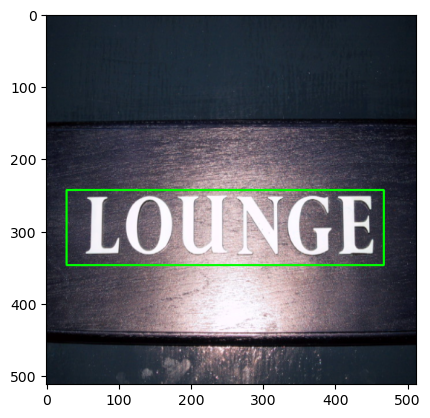

1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


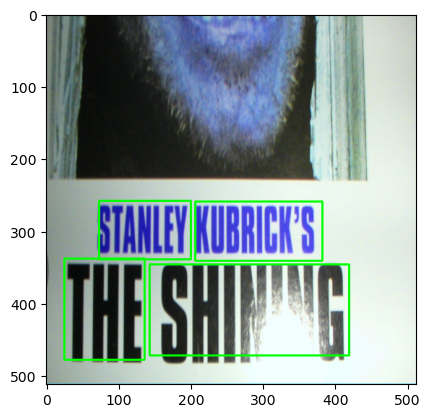

1/1 [==============================] - 0s 156ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


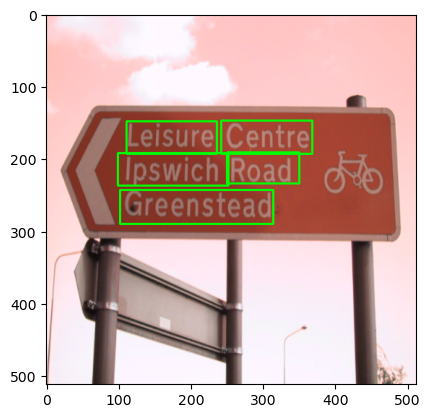

1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


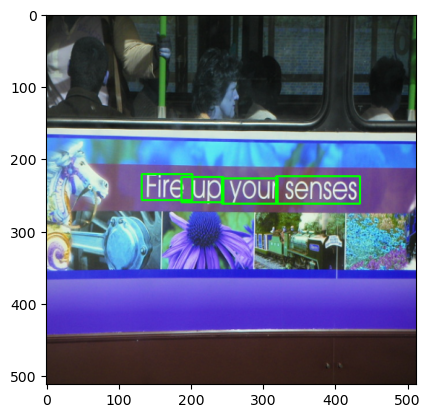

1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


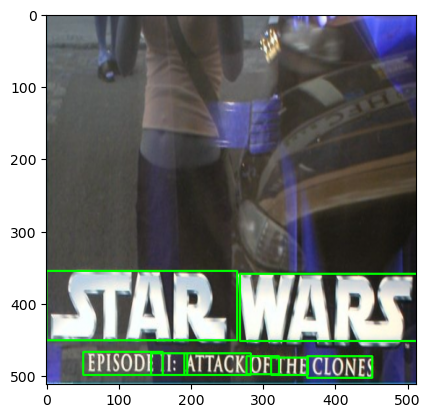

In [28]:
rand = np.random.randint(0,X_val.shape[0], size = 5)

for i in rand:
    
    predict_func(model , X_val[i:i+1] , 0.5, i)

# Creating GUI for Text Detection in Images

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


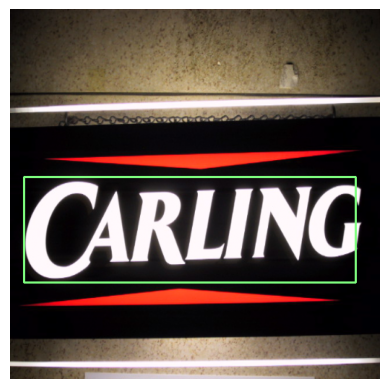

In [34]:
import tkinter as tk
from tkinter import filedialog
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to load an image and perform text detection
def load_and_detect():
    file_path = filedialog.askopenfilename()
    if file_path:
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512))  # Resize the image to match model input size
        img = (img - 127.5) / 127.5  # Normalize image

        ans = model.predict(np.expand_dims(img, axis=0))
        boxes = decode(ans[0], 512, 512, 0.5)

        for i in boxes:
            i = [int(x) for x in i]
            img = cv2.rectangle(img, (i[0], i[1]), (i[2], i[3]), color=(0, 255, 0), thickness=2)

        img = ((img + 1) / 2)  # Denormalize image

        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Create GUI
root = tk.Tk()
root.title("Text Detection GUI")

# Create Load Image button
load_button = tk.Button(root, text="Load Image & Detect Text", command=load_and_detect)
load_button.pack()

root.mainloop()
